/Users/nullhawk/miniconda3/lib/python3.12/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/nullhawk/miniconda3/lib/python3.12/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([16])) that is different to the input size (torch.Size([16, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch [10/1000] - Training Loss: 1605.0349, Test Loss: 1622.2676
Epoch [20/1000] - Training Loss: 1316.9942, Test Loss: 1324.9825
Epoch [30/1000] - Training Loss: 1091.0310, Test Loss: 1089.7766
Epoch [40/1000] - Training Loss: 913.5697, Test Loss: 903.7047
Epoch [50/1000] - Training Loss: 773.1909, Test Loss: 755.1702
Epoch [60/1000] - Training Loss: 662.4289, Test Loss: 636.5185
Epoch [70/1000] - Training Loss: 576.3408, Test Loss: 543.0359
Epoch [80/1000] - Training Loss: 510.2018, Test Loss: 470.4359
Epoch [90/1000] - Training Loss: 460.1009, Test Loss: 414.7835
Epoch [100/1000] - Training Loss: 423.3611, Test Loss: 372.5713
Epoch [110/1000] - Training Loss: 396.5623, Test Loss: 341.0636
Epoch [120/1000] - Training Loss: 377.6004, Test Loss: 318.1909
Epoch [130/1000] - Training Loss: 364.5269, Test Loss: 301.3683
Epoch [140/1000] - Training Loss: 355.6429, Test Loss: 289.5311
Epoch [150/1000] - Training Loss: 349.7210, Test Loss: 281.2161
Epoch [160/1000] - Training Loss: 345.9936,

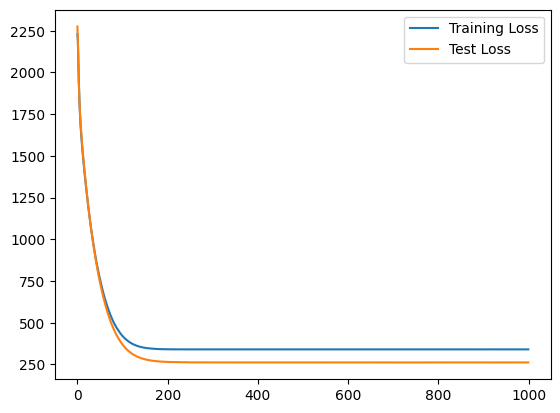

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
from sklearn.metrics import mean_absolute_error, mean_squared_error
from torch.utils.data import DataLoader, TensorDataset
from datetime import datetime

# Load Data
df = pd.read_csv("data/monatszahlen2412_verkehrsunfaelle_06_12_24.csv", usecols=["MONATSZAHL", "AUSPRAEGUNG", "JAHR", "MONAT", "WERT"])

# Filter Data for 'Alkoholunfälle' and 'insgesamt' category
df_filtered = df[
    (df["MONATSZAHL"] == "Alkoholunfälle") & 
    (df["AUSPRAEGUNG"] == "insgesamt") &
    (df['JAHR'] <= 2020)
]

# Remove non-integer months
df_filtered = df_filtered[df_filtered["MONAT"].str.isdigit()]

# Convert 'JAHR' and 'MONAT' to numeric
df_filtered['JAHR'] = df_filtered['JAHR'].astype(int)
df_filtered['MONAT'] = df_filtered['MONAT'].astype(int)

# # # Normalize 'WERT' column (number of accidents)
# scaler = MinMaxScaler()
# df_filtered['WERT'] = scaler.fit_transform(df_filtered[['WERT']])

# Prepare Data for Training
data = df_filtered[['JAHR', 'MONAT', 'WERT']].values
seq_length = 12  # Use a sliding window of 12 months

def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length, :-1])  # Use Year and Month as input features (exclude last column)
        y.append(data[i+seq_length, -1])    # Target: Value (last column)
    return np.array(X), np.array(y)

X, y = create_sequences(data, seq_length)

# Split into Train and Test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert to PyTorch tensors
X_train, y_train = torch.FloatTensor(X_train), torch.FloatTensor(y_train)
X_test, y_test = torch.FloatTensor(X_test), torch.FloatTensor(y_test)

# Define LSTM Model
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        predictions = self.fc(lstm_out[:, -1, :])  # Get predictions from the last time-step
        return predictions

# Hyperparameters
input_size = 2  # Year and Month as input features
hidden_size = 64
output_size = 1
num_layers = 3
batch_size = 32
num_epochs = 1000

# Initialize model, loss function, and optimizer
model = LSTMModel(input_size, hidden_size, output_size, num_layers)
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# DataLoader for batching
train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_loader = DataLoader(TensorDataset(X_test, y_test), batch_size=batch_size, shuffle=False)

# Training the Model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

train_hist = []
test_hist = []

for epoch in range(num_epochs):
    model.train()
    total_loss = 0.0
    for batch_X, batch_y in train_loader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        predictions = model(batch_X)
        loss = loss_fn(predictions, batch_y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    average_loss = total_loss / len(train_loader)
    train_hist.append(average_loss)

    model.eval()
    with torch.no_grad():
        total_test_loss = 0.0
        for batch_X_test, batch_y_test in DataLoader(TensorDataset(X_test, y_test), batch_size=batch_size, shuffle=False):
            batch_X_test, batch_y_test = batch_X_test.to(device), batch_y_test.to(device)
            predictions_test = model(batch_X_test)
            test_loss = loss_fn(predictions_test, batch_y_test)

            total_test_loss += test_loss.item()

        average_test_loss = total_test_loss / len(test_loader)
        test_hist.append(average_test_loss)

    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}] - Training Loss: {average_loss:.4f}, Test Loss: {average_test_loss:.4f}')

# Save the trained model
torch.save(model.state_dict(), 'model_checkpoint.pth')

# Plot Training and Test Losses
plt.plot(train_hist, label="Training Loss")
plt.plot(test_hist, label="Test Loss")
plt.legend()
plt.show()

# Make predictions for January 2021
model.eval()
input_data = np.array([[2020, 12]])  # December 2020 as input

# Create a dummy 'WERT' column to scale
dummy_wert = np.array([[0]])  # Dummy value, it will be replaced by the model's prediction
input_data_with_dummy_wert = np.hstack((input_data, dummy_wert))

# Scale the 'WERT' column only
input_data_scaled = input_data_with_dummy_wert.astype(float)
input_tensor = torch.FloatTensor(input_data_scaled).unsqueeze(0).to(device)

# with torch.no_grad():
#     prediction = model(input_tensor[:, :, :-1])  # Exclude the dummy 'WERT' column for prediction
#     prediction_value = scaler.inverse_transform(prediction.cpu().numpy())
#     print(f"Predicted number of accidents for January 2021: {prediction_value[0][0]}")


In [6]:

# Make predictions for January 2021
model.eval()
input_data = np.array([[2024, 12]])  # December 2020 as input

# Create a dummy 'WERT' column to scale
dummy_wert = np.array([[0]])  # Dummy value, it will be replaced by the model's prediction
input_data_with_dummy_wert = np.hstack((input_data, dummy_wert))

# Scale the 'WERT' column only
input_data_scaled = input_data_with_dummy_wert.astype(float)
input_tensor = torch.FloatTensor(input_data_scaled).unsqueeze(0).to(device)

with torch.no_grad():
    prediction = model(input_tensor[:, :, :-1])  # Exclude the dummy 'WERT' column for prediction
    # prediction_value = scaler.inverse_transform(prediction.cpu().numpy())
    # print(f"Predicted number of accidents for January 2021: {prediction_value[0][0]}")
    print(f"Predicted number of accidents for January 2021: {prediction}")

Predicted number of accidents for January 2021: tensor([[2.4148]])
